<a href="https://colab.research.google.com/github/kevinsu-rgb/Senior_Design_TI_Project/blob/main/ticnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is going to be the CNN model for the TI project. Here we begin with two classes Standing, and Falling.

In [19]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

%matplotlib inline

In [4]:
# THIS IS FAKE DATA IM USING FOR TESTING

import numpy as np
import pandas as pd
size = 20
heatmap_data = np.zeros((size, size))

center_x, center_y = size // 2, size // 2

for i in range(size):
    for j in range(size):
        distance = np.sqrt((i - center_x)**2 + (j - center_y)**2)
        heatmap_data[i, j] = np.exp(-0.1 * distance**2) * 100

df_heatmap = pd.DataFrame(heatmap_data)

df_heatmap.to_csv('data.csv', index=False)

Below we setup the training data for our NN.

In [5]:
## seed
seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [10]:
## load in the data
df = pd.read_csv('data.csv')
training_tensor = torch.tensor(df.values)

print(training_tensor[0:2])


tensor([[2.0612e-07, 1.3781e-06, 7.5435e-06, 3.3807e-05, 1.2405e-04, 3.7267e-04,
         9.1661e-04, 1.8458e-03, 3.0432e-03, 4.1080e-03, 4.5400e-03, 4.1080e-03,
         3.0432e-03, 1.8458e-03, 9.1661e-04, 3.7267e-04, 1.2405e-04, 3.3807e-05,
         7.5435e-06, 1.3781e-06],
        [1.3781e-06, 9.2136e-06, 5.0435e-05, 2.2603e-04, 8.2938e-04, 2.4916e-03,
         6.1283e-03, 1.2341e-02, 2.0347e-02, 2.7465e-02, 3.0354e-02, 2.7465e-02,
         2.0347e-02, 1.2341e-02, 6.1283e-03, 2.4916e-03, 8.2938e-04, 2.2603e-04,
         5.0435e-05, 9.2136e-06]], dtype=torch.float64)


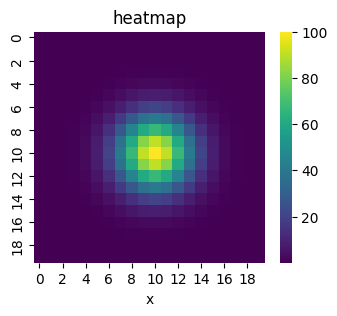

In [11]:

plt.figure(figsize=(4, 3))
sns.heatmap(df, cmap='viridis', cbar=True, square=True)
plt.title('heatmap')
plt.xlabel('x')
plt.ylabel('')
plt.show()

In [13]:
# Setup the device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [20]:
# Here is an example of the dataset I will use
class HeatmapDataset(Dataset):
    def __init__(self, labels_file, heatmap_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(labels_file)
        self.heatmap_dir = heatmap_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

This is the NN we are going to use to determine whether the heatmap represents standing, sitting, etc.. __I am going to change this when i see the data to do the following things:__
1. change the sizes of the tensors.
2. add a convolutional layer.

In [17]:
class NeuralNetwork(nn.Module):
  def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(28*28, 512),
          nn.ReLU(),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 10),
      )
  def forward(self, x):
      x = self.flatten(x)
      logits = self.linear_relu_stack(x)
      return logits